In [11]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import MultiTaskLassoCV
import plotly.graph_objs as go
from plotly.offline import plot, init_notebook_mode
import matplotlib.pyplot as plt

init_notebook_mode(connected=True)

In [12]:
# Create the feature matrix X
def create_feature_matrix(data, lags=[1, 2]):
    X = pd.DataFrame()
    for lag in lags:
        for ticker in data.columns:
            X[f'{ticker}_lag_{lag}'] = data[ticker].shift(lag)
    X = X.dropna()
    return X

In [13]:
# Split data into training and testing sets
def split_data(X, y):
    mid_point = len(X) // 2
    X_train, X_test = X[:mid_point], X[mid_point:]
    y_train, y_test = y[:mid_point], y[mid_point:]
    return X_train, X_test, y_train, y_test

In [14]:
# Function to evaluate model for given tickers and a target ticker
def evaluate_model(target_tickers, all_data, fixed_tickers, additional_tickers):
    results = []
    for k in range(0, 11):  # Loop to include up to 10 additional tickers
        tickers_used = fixed_tickers + additional_tickers[:k]
        if len(tickers_used) > 20:  # Stop after processing 20 tickers
            break
        try:
            print(f"Evaluating {len(tickers_used)} tickers for targets {target_tickers}: {tickers_used}")
            data_used = all_data[tickers_used]

            # Create the feature matrix using the selected tickers
            X = create_feature_matrix(data_used)
            y = all_data[target_tickers].loc[X.index]

            print(f"Data used shape: {data_used.shape}")
            print(f"Feature matrix shape: {X.shape}")

            if X.empty or y.empty:
                print(f"Skipping {len(tickers_used)} tickers: Empty DataFrame")
                continue

            # Adding additional features to X
            new_features = {}
            for ticker in tickers_used:
                if f'{ticker}_lag_1' in X.columns and f'{ticker}_lag_2' in X.columns:
                    diff_squared = (X[f'{ticker}_lag_1'] - X[f'{ticker}_lag_2']) ** 2
                    volatility = (X[f'{ticker}_lag_1'] - X[f'{ticker}_lag_2']) / X[f'{ticker}_lag_2']
                    new_features[f'{ticker}_diff_squared'] = diff_squared
                    new_features[f'{ticker}_volatility'] = volatility

            if new_features:
                new_features_df = pd.DataFrame(new_features, index=X.index)
                X = pd.concat([X, new_features_df], axis=1)
                X = X.copy()  # Create a de-fragmented copy of the DataFrame

            print(f"Feature matrix after adding new features shape: {X.shape}")

            # Splitting the data
            X_train, X_test, y_train, y_test = split_data(X, y)

            print(f"Train/Test split shapes: {X_train.shape}, {X_test.shape}")

            if X_train.empty or y_train.empty or X_test.empty or y_test.empty:
                print(f"Skipping {len(tickers_used)} tickers: Empty train/test split")
                continue

            # Splitting X_train into train1 (90%) and train2 (10%)
            train1_end = int(len(X_train) * 0.9)
            X_train1, X_train2 = X_train[:train1_end], X_train[train1_end:]
            y_train1, y_train2 = y_train[:train1_end], y_train[train1_end:]

            # Feature scaling
            scaler_X = StandardScaler().fit(X_train1)
            X_train1_scaled = scaler_X.transform(X_train1)
            X_train2_scaled = scaler_X.transform(X_train2)
            X_test_scaled = scaler_X.transform(X_test)

            scaler_Y = StandardScaler().fit(y_train1)
            y_train1_scaled = scaler_Y.transform(y_train1)
            y_train2_scaled = scaler_Y.transform(y_train2)
            y_test_scaled = scaler_Y.transform(y_test)

            # Debugging: Check the scaled values
            print(f"Scaled y_train1: {y_train1_scaled[:5]}")
            print(f"Scaled y_train2: {y_train2_scaled[:5]}")
            print(f"Scaled y_test: {y_test_scaled[:5]}")

            # Machine learning model with regularization
            multitask_lasso = MultiTaskLassoCV(max_iter=10000)  # Changed to MultiTaskLassoCV
            multitask_lasso.fit(X_train1_scaled, y_train1_scaled)

            # Predict using the model
            predicted_train1_scaled = multitask_lasso.predict(X_train1_scaled)
            predicted_train2_scaled = multitask_lasso.predict(X_train2_scaled)
            predicted_test_scaled = multitask_lasso.predict(X_test_scaled)

            # Compute Mean Squared Error (MSE)
            mse_train1 = np.mean(np.power(y_train1_scaled - predicted_train1_scaled, 2), axis=0)
            mse_train2 = np.mean(np.power(y_train2_scaled - predicted_train2_scaled, 2), axis=0)
            mse_test = np.mean(np.power(y_test_scaled - predicted_test_scaled, 2), axis=0)

            # Log MSE values
            print(f"MSE Train1: {mse_train1}, MSE Train2: {mse_train2}, MSE Test: {mse_test}")

            # Ensure arrays are 2D before inverse transforming
            predicted_train1_scaled = predicted_train1_scaled.reshape(-1, len(target_tickers))
            predicted_train2_scaled = predicted_train2_scaled.reshape(-1, len(target_tickers))
            predicted_test_scaled = predicted_test_scaled.reshape(-1, len(target_tickers))

            # Inverse transform the scaled predictions and actual values
            predicted_train1 = scaler_Y.inverse_transform(predicted_train1_scaled)
            predicted_train2 = scaler_Y.inverse_transform(predicted_train2_scaled)
            predicted_test = scaler_Y.inverse_transform(predicted_test_scaled)
            y_train1_inv = scaler_Y.inverse_transform(y_train1_scaled)
            y_train2_inv = scaler_Y.inverse_transform(y_train2_scaled)
            y_test_inv = scaler_Y.inverse_transform(y_test_scaled)

            # Evaluate direction accuracy
            direction_accuracy_train1 = np.mean((np.sign(np.diff(y_train1.values, axis=0)) == np.sign(np.diff(predicted_train1, axis=0))).astype(int), axis=0)
            direction_accuracy_train2 = np.mean((np.sign(np.diff(y_train2.values, axis=0)) == np.sign(np.diff(predicted_train2, axis=0))).astype(int), axis=0)
            direction_accuracy_test = np.mean((np.sign(np.diff(y_test.values, axis=0)) == np.sign(np.diff(predicted_test, axis=0))).astype(int), axis=0)

            print(f"Processed {len(tickers_used)} tickers")

            # Predictions and actual values for plotting
            predictions = {
                'y_train1': y_train1_inv,
                'y_train2': y_train2_inv,
                'y_test': y_test_inv,
                'predicted_train1': predicted_train1,
                'predicted_train2': predicted_train2,
                'predicted_test': predicted_test
            }

            for i, target in enumerate(target_tickers):
                results.append({
                    'Num_Tickers': len(tickers_used),
                    'Target_Ticker': target,
                    'MSE_Train1': mse_train1[i],
                    'MSE_Train2': mse_train2[i],
                    'MSE_Test': mse_test[i],
                    'Direction_Accuracy_Train1': direction_accuracy_train1[i],
                    'Direction_Accuracy_Train2': direction_accuracy_train2[i],
                    'Direction_Accuracy_Test': direction_accuracy_test[i],
                    'Predictions': {key: value[:, i] for key, value in predictions.items()}
                })

        except Exception as e:
            print(f"Error processing {len(tickers_used)} tickers: {e}")
            continue

    return results

In [15]:
ticker_list = ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'DIS', 'MA', 'UNH', 'HD', 'INTC', 'CSCO', 'PEP', 'VZ', 'KO', 'MRK', 'T', 'ABT', 'ABBV', 'PFE', 'NKE', 'ORCL', 'CRM', 'MCD', 'MS', 'COST', 'WFC', 'CVX', 'BA', 'RTX', 'IBM', 'GS', 'QCOM', 'HON', 'AMD', 'SBUX', 'ISRG', 'NOW', 'SPGI', 'BKNG', 'DHR', 'BLK', 'MDT', 'AMAT', 'CAT', 'DE', 'GE', 'GILD', 'ADBE', 'TMO', 'AXP', 'DUK', 'USB', 'AMGN', 'SYK', 'ADI', 'ZTS', 'CVS', 'C', 'COP', 'CL', 'ECL', 'APD', 'SHW', 'ICE', 'LMT', 'LRCX', 'ETN', 'FDX', 'VRTX', 'MPC', 'TGT', 'BMY', 'NSC', 'CI', 'REGN', 'DD', 'TRV', 'CMG', 'AON', 'F', 'GM', 'APTV', 'APH', 'CDW', 'KMB', 'BSX']

In [16]:
# Download data for all tickers
all_data = yf.download(ticker_list, start='2010-06-29', end='2014-06-24')['Adj Close']

[*********************100%%**********************]  94 of 94 completed


In [17]:
# Fill missing values and forward-fill any remaining missing data
all_data.ffill(inplace=True)
all_data.bfill(inplace=True)

In [18]:
# Evaluate models for different number of tickers in the feature matrix
fixed_tickers = ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM']
additional_tickers = [ticker for ticker in ticker_list if ticker not in fixed_tickers]
target_tickers = ['GOOGL', 'AAPL', 'AMZN']

In [19]:
results = evaluate_model(target_tickers, all_data, fixed_tickers, additional_tickers)

# Check the structure of results
print("Results Structure:", results)

Evaluating 10 tickers for targets ['GOOGL', 'AAPL', 'AMZN']: ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'V', 'JPM']
Data used shape: (1003, 10)
Feature matrix shape: (1001, 20)
Feature matrix after adding new features shape: (1001, 40)
Train/Test split shapes: (500, 40), (501, 40)
Scaled y_train1: [[-2.41185821 -1.41361622 -2.54577301]
 [-2.46730106 -1.4321934  -2.61112059]
 [-2.47635302 -1.41180579 -2.57808778]
 [-2.20988515 -1.29068532 -2.45708683]
 [-2.08994605 -1.29768357 -2.35691147]]
Scaled y_train2: [[1.07901521 2.89013187 0.23688304]
 [0.7295687  2.5873326  0.13060303]
 [0.79557373 2.94405582 0.23436968]
 [0.75559355 2.92764895 0.33059558]
 [0.60189718 2.67551741 0.33167284]]
Scaled y_test: [[-0.12603467  2.47441328  1.37184726]
 [-0.0509791   2.48961535  1.57076257]
 [ 0.03614743  2.51941137  1.57112142]
 [-0.05795605  2.45366427  1.41636995]
 [ 0.23925153  2.63401787  1.66914229]]
MSE Train1: [0.03337905 0.00452708 0.02092556], MSE Train2: [0.04123271 0

Results DataFrame Head:    Num_Tickers Target_Ticker  MSE_Train1  MSE_Train2  MSE_Test  \
0           10         GOOGL    0.033379    0.041233  0.126685   
1           10          AAPL    0.004527    0.025690  0.043626   
2           10          AMZN    0.020926    0.042230  0.267600   
3           11         GOOGL    0.033145    0.039495  0.147642   
4           11          AAPL    0.004503    0.025212  0.051598   

   Direction_Accuracy_Train1  Direction_Accuracy_Train2  \
0                   0.543430                   0.387755   
1                   0.543430                   0.448980   
2                   0.485523                   0.428571   
3                   0.536748                   0.387755   
4                   0.545657                   0.448980   

   Direction_Accuracy_Test                                        Predictions  
0                    0.530  {'y_train1': [10.985639572143555, 10.912151336...  
1                    0.532  {'y_train1': [7.502788543701172, 7.4

,Num_Tickers,Target_Ticker,MSE_Train1,MSE_Train2,MSE_Test,Direction_Accuracy_Train1,Direction_Accuracy_Train2,Direction_Accuracy_Test,Predictions
0,10,GOOGL,0.033379,0.041233,0.126685,0.543430,0.387755,0.530,"{'y_train1': [10.985639572143555, 10.912151336..."
1,10,AAPL,0.004527,0.025690,0.043626,0.543430,0.448980,0.532,"{'y_train1': [7.502788543701172, 7.45629119873..."
2,10,AMZN,0.020926,0.042230,0.267600,0.485523,0.428571,0.490,"{'y_train1': [5.547999858856201, 5.45699977874..."
3,11,GOOGL,0.033145,0.039495,0.147642,0.536748,0.387755,0.528,"{'y_train1': [10.985639572143555, 10.912151336..."
4,11,AAPL,0.004503,0.025212,0.051598,0.545657,0.448980,0.534,"{'y_train1': [7.502788543701172, 7.45629119873..."
5,11,AMZN,0.020717,0.042191,0.304396,0.483296,0.387755,0.484,"{'y_train1': [5.547999858856201, 5.45699977874..."
6,12,GOOGL,0.032191,0.045579,0.265581,0.525612,0.408163,0.534,"{'y_train1': [10.985639572143555, 10.912151336..."
7,12,AAPL,0.004422,0.025675,0.035290,0.556793,0.408163,0.544,"{'y_train1': [7.502788543701172, 7.45629119873..."
8,12,AMZN,0.020300,0.049532,0.407711,0.510022,0.408163,0.484,"{'y_train1': [5.547999858856201, 5.45699977874..."
9,13,GOOGL,0.032156,0.048116,0.258184,0.525612,0.408163,0.532,"{'y_train1': [10.985639572143555, 10.912151336..."


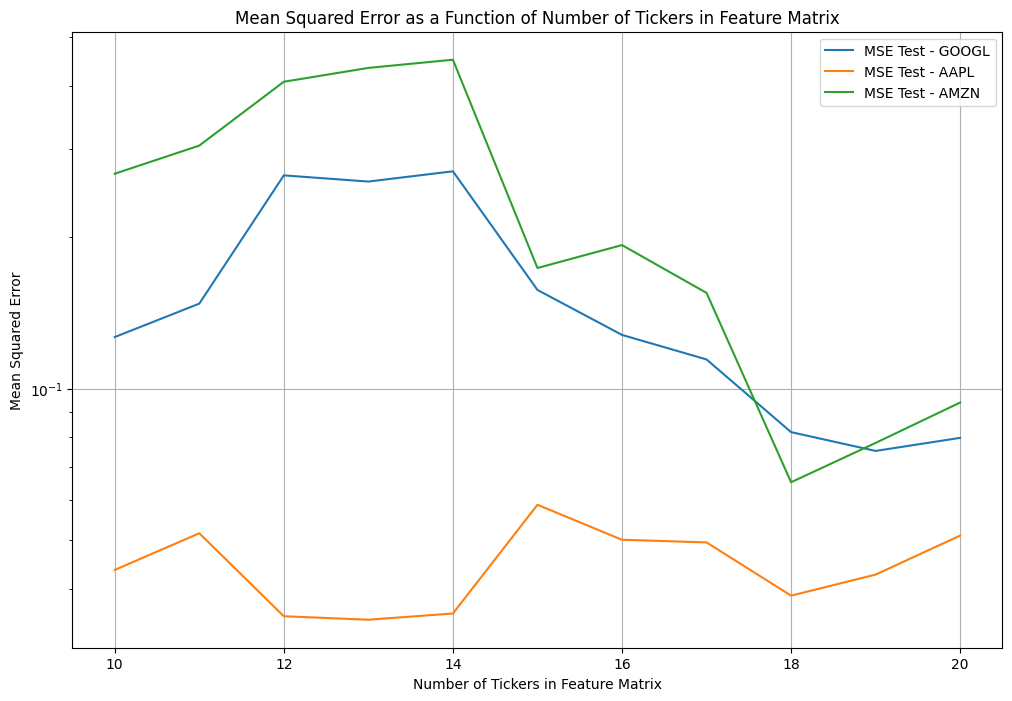

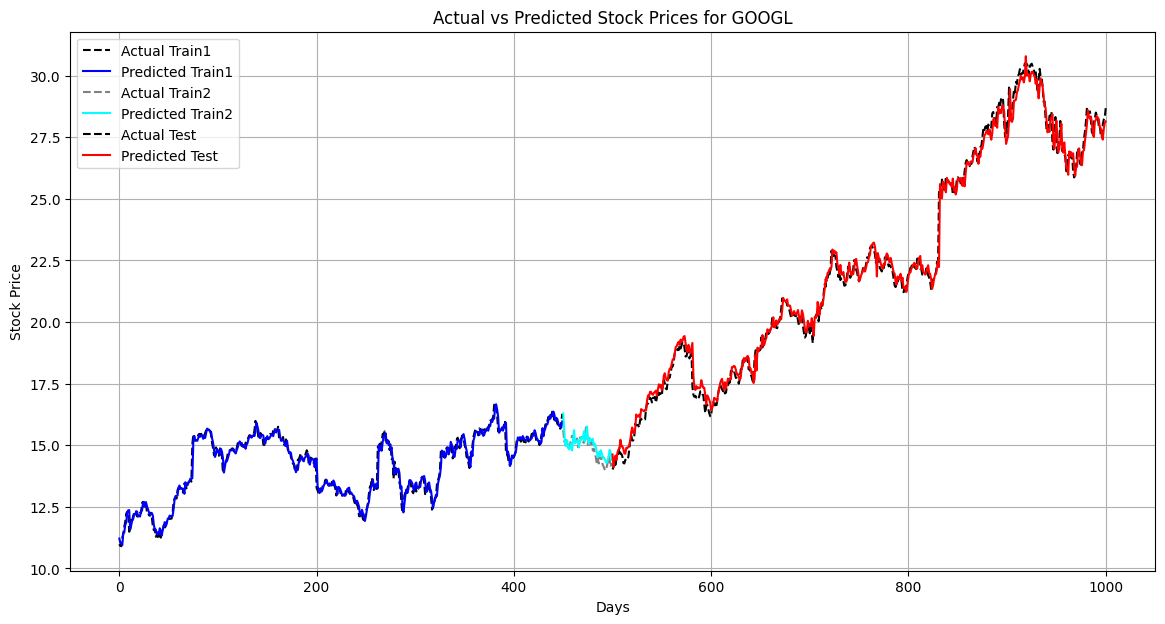

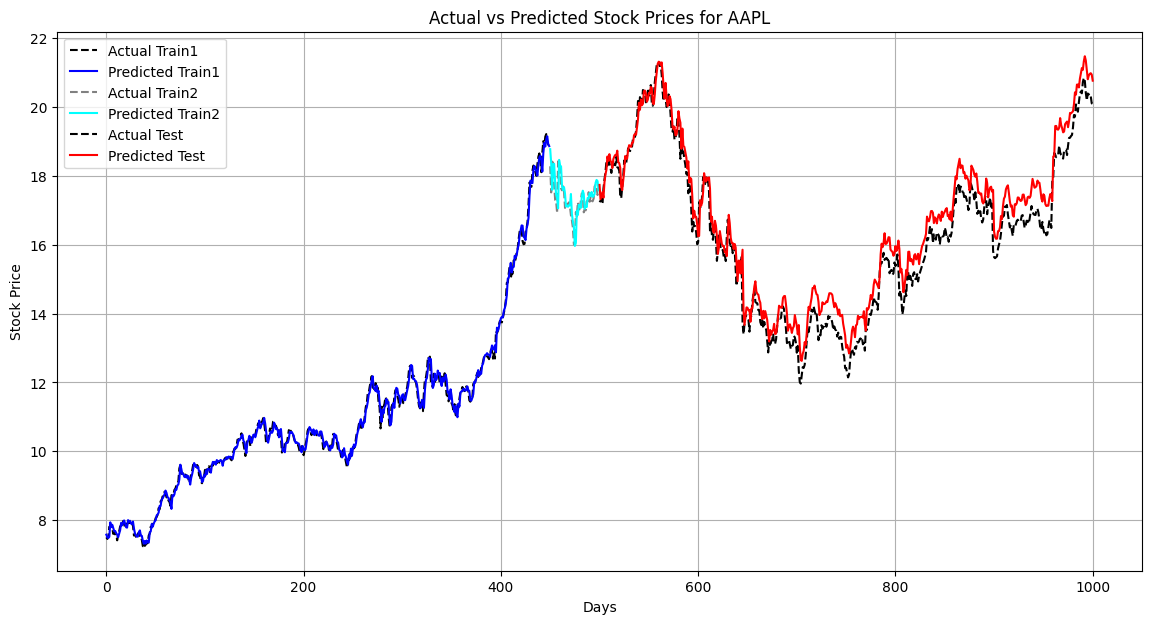

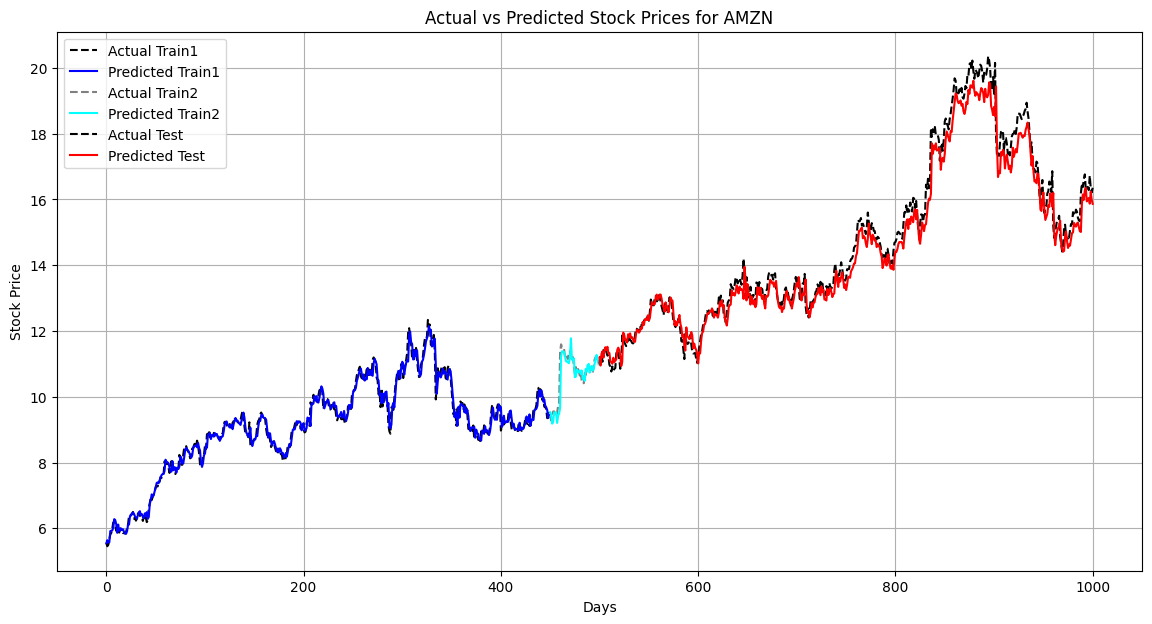

In [20]:
# Convert results to DataFrame
if results:
    results_df = pd.DataFrame(results)
    print("Results DataFrame Head:", results_df.head())

    # Save final results
    results_df.to_csv('final_results.csv', index=False)

    # Display the DataFrame in a Jupyter notebook environment
    display(results_df)

    # Plot Mean Squared Errors (MSE) for Google, Apple, and Amazon
    plt.figure(figsize=(12, 8))
    for target in target_tickers:
        plt.plot(results_df[results_df['Target_Ticker'] == target]['Num_Tickers'], results_df[results_df['Target_Ticker'] == target]['MSE_Test'], label=f'MSE Test - {target}', linestyle='solid')

    plt.xlabel('Number of Tickers in Feature Matrix')
    plt.ylabel('Mean Squared Error')
    plt.title('Mean Squared Error as a Function of Number of Tickers in Feature Matrix')
    plt.legend()
    plt.grid(True)
    plt.yscale('log')
    plt.show()

    # Function to plot actual vs predicted stock prices
    def plot_actual_vs_predicted(predictions, target):
        plt.figure(figsize=(14, 7))
        plt.plot(predictions['y_train1'], label='Actual Train1', color='black', linestyle='dashed')
        plt.plot(predictions['predicted_train1'], label='Predicted Train1', color='blue')
        plt.plot(range(len(predictions['y_train1']), len(predictions['y_train1']) + len(predictions['y_train2'])), predictions['y_train2'], label='Actual Train2', color='gray', linestyle='dashed')
        plt.plot(range(len(predictions['y_train1']), len(predictions['y_train1']) + len(predictions['y_train2'])), predictions['predicted_train2'], label='Predicted Train2', color='cyan')
        plt.plot(range(len(predictions['y_train1']) + len(predictions['y_train2']), len(predictions['y_train1']) + len(predictions['y_train2']) + len(predictions['y_test'])), predictions['y_test'], label='Actual Test', color='black', linestyle='dashed')
        plt.plot(range(len(predictions['y_train1']) + len(predictions['y_train2']), len(predictions['y_train1']) + len(predictions['y_train2']) + len(predictions['y_test'])), predictions['predicted_test'], label='Predicted Test', color='red')
        plt.xlabel('Days')
        plt.ylabel('Stock Price')
        plt.title(f'Actual vs Predicted Stock Prices for {target}')
        plt.legend()
        plt.grid(True)
        plt.show()

    # Plot the actual vs predicted stock prices for Google, Apple, and Amazon using the last evaluated model
    for target in target_tickers:
        plot_actual_vs_predicted(results_df[results_df['Target_Ticker'] == target]['Predictions'].iloc[-1], target)
else:
    print("No results to display.")
